In [1]:
import heapq
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Paramètres globaux
N_SERVEURS = 12
QUEUE_SIZE = 100
C_VALUES = [1, 2, 3, 6]
LAMBDA_VALUES = np.linspace(0.1, 2, 10)  # Valeurs de lambda à tester
SIMULATION_TIME = 10000  # Temps total de simulation
CONFIDENCE_LEVEL = 1.96  # Intervalle de confiance à 95%

In [3]:
# Génération de variables exponentielles
def exp_rnd(lmbda):
    return -np.log(np.random.uniform()) / lmbda

In [7]:
class Requete:
    def __init__(self, time, category):
        self.time = time  # Temps d'arrivée
        self.category = category  # Catégorie de la requête

class Serveur:
    def __init__(self):
        self.busy = False
        self.end_time = 0

class Routeur:
    def __init__(self, C):
        self.queue = []  # File d'attente FIFO
        self.capacity = QUEUE_SIZE
        self.C = C  # Nombre de groupes
        self.servers = {i: [Serveur() for _ in range(N_SERVEURS // C)] for i in range(C)}
        self.loss_count = 0  # Nombre de requêtes perdues

    def receive_request(self, event_queue, current_time, request):
        if len(self.queue) < self.capacity:
            self.queue.append(request)
            heapq.heappush(event_queue, (current_time + (self.C - 1) / self.C, 'route_request'))
        else:
            self.loss_count += 1  # Requête perdue

    def route_request(self, event_queue, current_time):
        if self.queue:
            request = self.queue.pop(0)
            group = request.category % self.C
            servers = self.servers[group]
            
            for server in servers:
                if not server.busy:
                    server.busy = True
                    service_time = exp_rnd({1: 4/20, 2: 7/20, 3: 10/20, 6: 14/20}[self.C])
                    server.end_time = current_time + service_time
                    heapq.heappush(event_queue, (server.end_time, 'end_service', server, group))
                    return
            
            self.queue.insert(0, request)  # Remet la requête si aucun serveur libre

    def end_service(self, event_queue, current_time, server, group):
        server.busy = False
        if self.queue:
            self.route_request(event_queue, current_time)

In [8]:
def simulate(C, lmbda):
    event_queue = []  # File d'événements (min-heap)
    routeur = Routeur(C)
    current_time = 0
    request_count = 0
    total_response_time = []
    
    # Génération de la première arrivée
    heapq.heappush(event_queue, (exp_rnd(lmbda), 'arrival'))
    
    while current_time < SIMULATION_TIME and event_queue:
        current_time, event, *args = heapq.heappop(event_queue)
        
        if event == 'arrival':
            category = np.random.randint(0, C)
            request = Requete(current_time, category)
            routeur.receive_request(event_queue, current_time, request)
            heapq.heappush(event_queue, (current_time + exp_rnd(lmbda), 'arrival'))
            request_count += 1
        
        elif event == 'route_request':
            routeur.route_request(event_queue, current_time)
        
        elif event == 'end_service':
            server, group = args
            routeur.end_service(event_queue, current_time, server, group)
            total_response_time.append(current_time)
    
    avg_response_time = np.mean(total_response_time) if total_response_time else float('inf')
    loss_rate = routeur.loss_count / request_count if request_count else 0
    return avg_response_time, loss_rate


In [9]:
# Exécution de la simulation et tracé des résultats
response_times = {C: [] for C in C_VALUES}
loss_rates = {C: [] for C in C_VALUES}

for C in C_VALUES:
    for lmbda in LAMBDA_VALUES:
        avg_time, loss_rate = simulate(C, lmbda)
        response_times[C].append(avg_time)
        loss_rates[C].append(loss_rate)


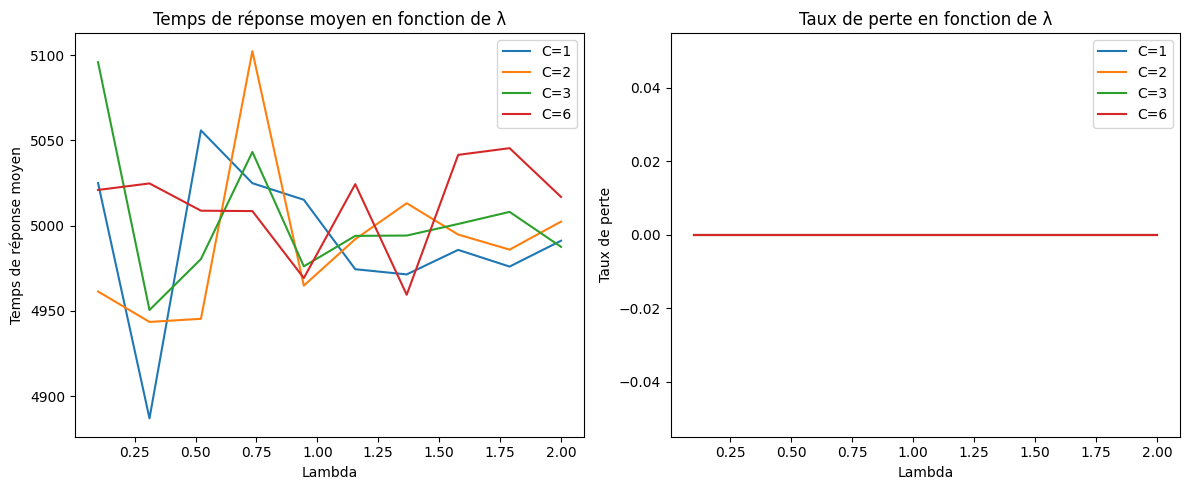

In [10]:
# Tracé des courbes
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for C in C_VALUES:
    plt.plot(LAMBDA_VALUES, response_times[C], label=f'C={C}')
plt.xlabel('Lambda')
plt.ylabel('Temps de réponse moyen')
plt.title('Temps de réponse moyen en fonction de λ')
plt.legend()

plt.subplot(1, 2, 2)
for C in C_VALUES:
    plt.plot(LAMBDA_VALUES, loss_rates[C], label=f'C={C}')
plt.xlabel('Lambda')
plt.ylabel('Taux de perte')
plt.title('Taux de perte en fonction de λ')
plt.legend()

plt.tight_layout()
plt.show()